# Model Evaluation

## 1. Setup

In [7]:
# NECESSARY IMPORTS
import pandas as pd
import numpy  as np

from keras.models     import Sequential
from keras.layers     import Dense, Dropout, Activation, Flatten, advanced_activations
from keras.layers     import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam

from keras import initializations
import keras.backend     as K
import matplotlib.pyplot as plt

from pandas                     import Series
from scipy.misc                 import imresize
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image  import (ImageDataGenerator, 
                                        array_to_img,
                                        img_to_array,
                                        load_img)
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [8]:
%matplotlib inline

In [9]:
dir(initializations.normal)

['__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__hash__',
 '__init__',
 '__module__',
 '__name__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'func_closure',
 'func_code',
 'func_defaults',
 'func_dict',
 'func_doc',
 'func_globals',
 'func_name']

In [10]:
# Ensure reproducibility
np.random.seed(0)

In [11]:
# Path constants
DATA_TEMPLATE     = "./../../data/"
ADIENCE_META_P    = DATA_TEMPLATE + "adience/meta"
ADIENCE_RAW_P     = DATA_TEMPLATE + "adience/keras_format"
ADIENCE_AGE_P     = ADIENCE_RAW_P + "/age"
ADIENCE_GEN_P     = ADIENCE_RAW_P + "/gender"
IMG_PATH          = DATA_TEMPLATE + "wiki/%s"

WIKI_META_P       = DATA_TEMPLATE + "wiki_meta"
MODEL_TEMPLATE    = "./models/%s"
WEIGHTS_TEMPLATE  = "./weights/%s"
GRAPHS_TEMPLATE   = "./graphs/%s"
HISTORY_TEMPLATE   = "./graphs/%s"

In [12]:
# Independent constants
MODEL_NAME = "1_age_SGD1e3_randomNormal_LHet_LeakyReLu"
INITIALIZATION = 'normal'
LOSS           = "categorical_crossentropy"
OPTIMIZER      = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
BATCH_SIZE     = 32


PIC_NAME     = GRAPHS_TEMPLATE % (MODEL_NAME + ".png")
PIC_NAME_FINETUNING = GRAPHS_TEMPLATE % (MODEL_NAME + "_finetuning_.png")
WEIGHTS_NAME = WEIGHTS_TEMPLATE % (MODEL_NAME + ".h5")
TRA_HISTORY_NAME = HISTORY_TEMPLATE % (MODEL_NAME + "_train_"+".npy")
VAL_HISTORY_NAME = HISTORY_TEMPLATE % (MODEL_NAME + "_valid_"+".npy")


WEIGHTS_NAME_FINETUNING = WEIGHTS_TEMPLATE % (MODEL_NAME + "_finetuning_.h5")
TRA_HISTORY_NAME_FINETUNING = HISTORY_TEMPLATE % (MODEL_NAME + "_train_"+"_finetuning_.npy")
VAL_HISTORY_NAME_FINETUNING = HISTORY_TEMPLATE % (MODEL_NAME + "_valid_"+"_finetuning_.npy")

IMG_WIDTH  = 227
IMG_HEIGHT = 227


ADIENCE_FULL = ["idx","user_id","face_id","original_image","gender","age","img_path","keras_path"]
ADIENCE_HEADER = ["user_id","face_id","original_image","gender","age","img_path","keras_path"]
WIKI_HEADER    = ["full_path","age","gender"]

NUM_EPOCHS = 1000

In [13]:
# Dependent constants
IMG_DIMS = (IMG_WIDTH, IMG_HEIGHT)
MODEL_W  = MODEL_NAME + ".h5"
MODEL_P  = MODEL_NAME + ".txt" 

## 2. Loading metadata

### Adience

In [14]:
gender_train_path = ADIENCE_META_P + "/gender_train_0.csv"
gender_valid_path = ADIENCE_META_P + "/gender_valid_0.csv"
gender_train = pd.read_csv(filepath_or_buffer =gender_train_path)
gender_valid = pd.read_csv(filepath_or_buffer =gender_valid_path)

gender_train = gender_train[ADIENCE_HEADER]
gender_valid = gender_valid[ADIENCE_HEADER]

In [15]:
age_train_path = ADIENCE_META_P + "/age_train_0.csv"
age_valid_path = ADIENCE_META_P + "/age_valid_0.csv"
age_train = pd.read_csv(filepath_or_buffer =gender_train_path)
age_valid = pd.read_csv(filepath_or_buffer =gender_valid_path)

age_train = age_train[ADIENCE_HEADER]
age_valid = age_valid[ADIENCE_HEADER]

### Wiki

In [16]:
w_gender_train_path = WIKI_META_P + "/gender/train_1.csv"
w_gender_valid_path = WIKI_META_P + "/gender/valid_1.csv"

w_gender_train = pd.read_csv(filepath_or_buffer =w_gender_train_path)
w_gender_valid = pd.read_csv(filepath_or_buffer =w_gender_valid_path)

w_gender_train = w_gender_train[WIKI_HEADER]
w_gender_valid = w_gender_valid[WIKI_HEADER]

In [17]:
w_age_train_path = WIKI_META_P + "/gender/train_1.csv"
w_age_valid_path = WIKI_META_P + "/gender/valid_1.csv"
w_age_train = pd.read_csv(filepath_or_buffer =w_age_train_path)
w_age_valid = pd.read_csv(filepath_or_buffer =w_age_valid_path)

w_age_train = w_age_train[WIKI_HEADER]
w_age_valid = w_age_valid[WIKI_HEADER]

### SHALLOW-ONLY TASK: Fix age ranges

In [18]:
def fix_age_ranges(age):
    if age < 4:
        return "(0, 2)"
    if age < 8:
        return "(4, 6)"
    if age < 15:
        return "(8, 13)"
    if age < 25:
        return "(15, 20)"
    if age < 38:
        return "(25, 32)"
    if age < 48:
        return "(38, 43)"
    if age < 60:
        return "(48, 53)"
    return "(60-100)"

w_age_train["age"]    = w_age_train["age"].apply(lambda x: fix_age_ranges(x))
w_age_valid["age"]    = w_age_valid["age"].apply(lambda x: fix_age_ranges(x))
w_gender_train["age"] = w_gender_train["age"].apply(lambda x: fix_age_ranges(x))
w_gender_valid["age"] = w_gender_valid["age"].apply(lambda x: fix_age_ranges(x))

## 3. Data pipeline

### 3.1 Adience

In [19]:
adience_train_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [20]:
adience_valid_aug = ImageDataGenerator()

### Train

In [21]:
ADIENCE_GENDER_TRAIN_P = ADIENCE_GEN_P + "/train/1"
adience_gender_train_gen = adience_train_aug.flow_from_directory(
    ADIENCE_GENDER_TRAIN_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 10505 images belonging to 2 classes.


In [22]:
ADIENCE_AGE_TRAIN_P = ADIENCE_AGE_P + "/train/1"
adience_age_train_gen = adience_train_aug.flow_from_directory(
    ADIENCE_AGE_TRAIN_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 10505 images belonging to 8 classes.


### Validation

In [23]:
ADIENCE_GENDER_VALID_P = ADIENCE_GEN_P + "/valid/1"
adience_gender_valid_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_GENDER_VALID_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3502 images belonging to 2 classes.


In [24]:
ADIENCE_AGE_VALID_P = ADIENCE_AGE_P + "/valid/1"
adience_age_valid_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_AGE_VALID_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3502 images belonging to 8 classes.


### Test

In [25]:
ADIENCE_GENDER_TEST_P = ADIENCE_AGE_P + "/test/"
adience_gender_test_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_GENDER_TEST_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3445 images belonging to 8 classes.


In [26]:
ADIENCE_AGE_TEST_P = ADIENCE_AGE_P + "/test/"
adience_age_test_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_AGE_TEST_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3445 images belonging to 8 classes.


### 3.2 Wiki

In [27]:
true_path = lambda x: IMG_PATH % x
w_age_train["full_path"]    = w_age_train["full_path"].apply(lambda x: true_path(x))
w_gender_train["full_path"] = w_gender_train["full_path"].apply(lambda x: true_path(x))
w_age_valid["full_path"]    = w_age_valid["full_path"].apply(lambda x: true_path(x))
w_gender_valid["full_path"] = w_gender_valid["full_path"].apply(lambda x: true_path(x))

In [28]:
def get_image(x):
    try:
        val = img_to_array(imresize(load_img(x),IMG_DIMS))
    except:
        val = "ERR"
    return val

In [29]:
# Data generator
def generate_data(df, batch_size, target_feature):
    start, end = 0, batch_size
    while True:
        data   = df.sample(frac=1).reset_index(drop=True)
        ages_h = list(pd.get_dummies(data["age"]).columns.values)
        ages   = pd.get_dummies(data["age"])
        data[ages_h] = ages
        
        sample = data[start:end]
        
        X         = pd.DataFrame(sample["full_path"].apply(lambda x:get_image(x)))
        good_rows = X["full_path"] != "ERR"
        X         = X[good_rows]
        X.reset_index(inplace=True)
        X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
        X = np.vstack(X)
        #X = model.predict(X, X.shape[0])
        
        Y = sample[good_rows]
        if target_feature == "age":
            Y = Y[ages_h].as_matrix()
        else:
            Y = Y[target_feature].as_matrix()
        yield (X,Y)

In [30]:
# Data generator
def generate_test(df, batch_size, target_feature):
    start, end = 0, batch_size
    while True:
        while end < len(dfs.shape[0]):
            ages_h = list(pd.get_dummies(data["age"]).columns.values)
            ages   = pd.get_dummies(data["age"])
            data[ages_h] = ages

            sample = data[start:end]
            start += batch_size
            end   += batch_size

            X         = pd.DataFrame(sample["full_path"].apply(lambda x:get_image(x)))
            good_rows = X["full_path"] != "ERR"
            X         = X[good_rows]
            X.reset_index(inplace=True)
            X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
            X = np.vstack(X)
            #X = model.predict(X, X.shape[0])

            Y = sample[good_rows]
            if target_feature == "age":
                Y = Y[ages_h].as_matrix()
            else:
                Y = Y[target_feature].as_matrix()
            yield (X,Y)

In [31]:
w_age_train_gen = generate_data(w_age_train, BATCH_SIZE, "age")
w_age_valid_gen = generate_data(w_age_valid, BATCH_SIZE, "age")
w_gender_train_gen = generate_data(w_gender_train, BATCH_SIZE, "gender")
w_gender_valid_gen = generate_data(w_gender_valid, BATCH_SIZE, "gender")

In [32]:
X, Y = w_age_valid_gen.next()

/usr/local/lib/python2.7/dist-packages/pandas/core/ops.py:739: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)


In [33]:
from keras.engine.topology import Layer
class LRN2D(Layer):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = X.shape
        half_n = self.n // 2
        input_sqr = T.sqr(X)
        extra_channels = T.alloc(0., b, ch + 2*half_n, r, c)
        input_sqr = T.set_subtensor(extra_channels[:, half_n:half_n+ch, :, :], input_sqr)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        return {"name": self.__class__.__name__,
                "alpha": self.alpha,
                "k": self.k,
                "beta": self.beta,
"n": self.n}

## 4. Building the model

In [34]:
# Building a vainilla CNN
model = Sequential()
model.add(Convolution2D(96, 7, 7, input_shape=(IMG_WIDTH,IMG_HEIGHT,3), init=INITIALIZATION))
model.add(advanced_activations.LeakyReLU(alpha=0.009))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
model.add(LRN2D())

model.add(Convolution2D(256, 5, 5, init=INITIALIZATION))
model.add(advanced_activations.LeakyReLU(alpha=0.009))
model.add(Convolution2D(64, 3, 3, init=INITIALIZATION))
model.add(advanced_activations.LeakyReLU(alpha=0.009))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(LRN2D())

model.add(Convolution2D(384, 3, 3, init=INITIALIZATION))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(output_dim=512,input_dim=512, init=INITIALIZATION))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(output_dim=512,input_dim=512, init=INITIALIZATION))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(output_dim=8))
model.add(Activation("softmax"))


In [35]:
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy', 'recall', 'precision','f1score'])

## 6. Training the model

In [36]:
history = model.fit_generator(w_age_train_gen, 
                              validation_data=w_age_valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS)

Epoch 1/1000
32/32 [==============================] - 8s - loss: 12.5923 - acc: 0.2188 - recall: 0.2188 - precision: 0.2188 - fmeasure: 0.2187 - val_loss: 15.1107 - val_acc: 0.0625 - val_recall: 0.0625 - val_precision: 0.0625 - val_fmeasure: 0.0625
Epoch 2/1000
32/32 [==============================] - 1s - loss: 14.1033 - acc: 0.1250 - recall: 0.1250 - precision: 0.1250 - fmeasure: 0.1250 - val_loss: 16.1181 - val_acc: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 3/1000
32/32 [==============================] - 1s - loss: 15.6144 - acc: 0.0312 - recall: 0.0312 - precision: 0.0312 - fmeasure: 0.0312 - val_loss: 14.1033 - val_acc: 0.1250 - val_recall: 0.1250 - val_precision: 0.1250 - val_fmeasure: 0.1250
Epoch 4/1000
32/32 [==============================] - 1s - loss: 13.5996 - acc: 0.1562 - recall: 0.1562 - precision: 0.1562 - fmeasure: 0.1562 - val_loss: 14.6070 - val_acc: 0.0938 - val_recall: 0.0938 - val_precision: 0.0938 - val_fmeas

## 7. Evaluating the results

In [37]:
train_history = history.history['acc']
valid_history = history.history['val_acc']

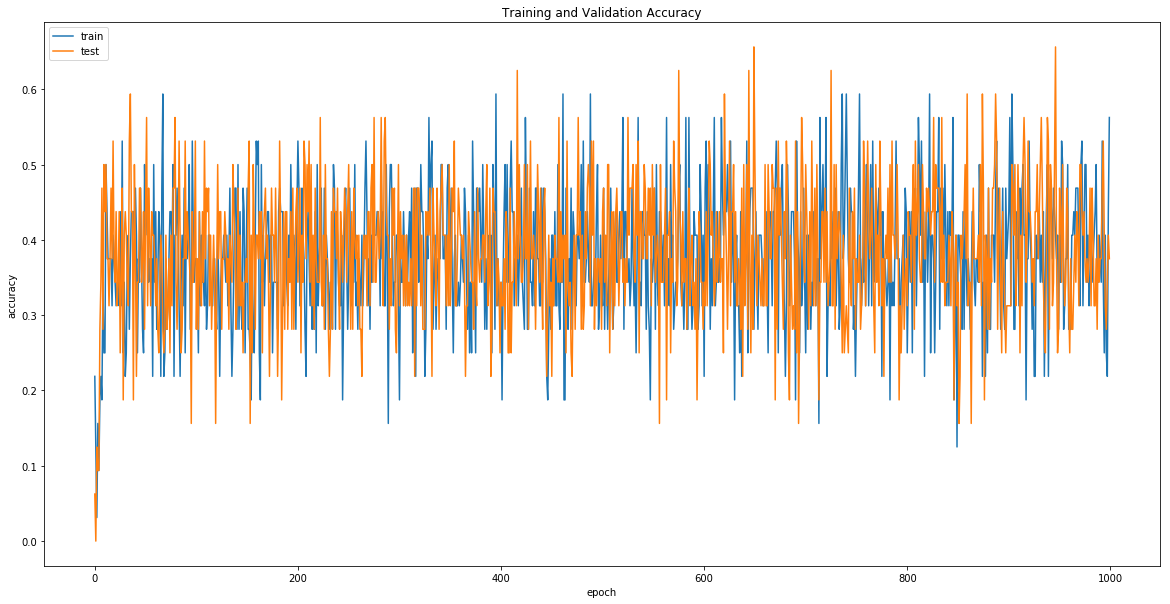

In [38]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(train_history)
plt.plot(valid_history)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(PIC_NAME)

In [39]:
# Tail-rolling average transform
series_train = Series(train_history)
rolling_train = series_train.rolling(window=100)
rolling_mean_train = rolling_train.mean()

series_valid = Series(valid_history)
rolling_valid = series_valid.rolling(window=100)
rolling_mean_valid = rolling_valid.mean()

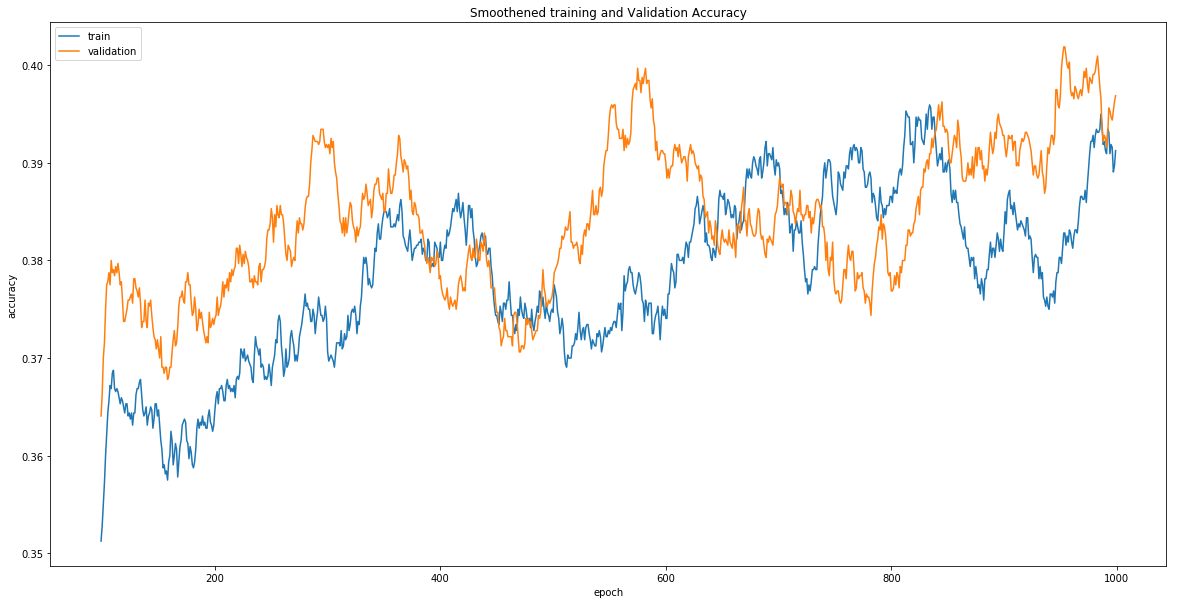

In [40]:
plt.figure(figsize=(20,10))
plt.plot(rolling_mean_train)
plt.plot(rolling_mean_valid)
plt.title('Smoothened training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
# Saving histories
np.save(TRA_HISTORY_NAME, train_history)
np.save(VAL_HISTORY_NAME, valid_history)

In [42]:
# saving weights
model.save_weights(WEIGHTS_NAME)

### Results on Adience

In [43]:
model.evaluate_generator(adience_age_test_gen,BATCH_SIZE*400)

[11.079541830324938,
 0.31260229141860285,
 0.31260229136982653,
 0.31260229136982653,
 0.31260223377197832]

## Finetuning with Adience

In [44]:
history = model.fit_generator(adience_age_train_gen, 
                              validation_data=adience_age_valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS)

Epoch 1/1000
32/32 [==============================] - 2s - loss: 12.0886 - acc: 0.2500 - recall: 0.2500 - precision: 0.2500 - fmeasure: 0.2500 - val_loss: 10.0738 - val_acc: 0.3750 - val_recall: 0.3750 - val_precision: 0.3750 - val_fmeasure: 0.3750
Epoch 2/1000
32/32 [==============================] - 2s - loss: 11.0812 - acc: 0.3125 - recall: 0.3125 - precision: 0.3125 - fmeasure: 0.3125 - val_loss: 13.0960 - val_acc: 0.1875 - val_recall: 0.1875 - val_precision: 0.1875 - val_fmeasure: 0.1875
Epoch 3/1000
32/32 [==============================] - 2s - loss: 10.5775 - acc: 0.3438 - recall: 0.3438 - precision: 0.3438 - fmeasure: 0.3437 - val_loss: 12.5923 - val_acc: 0.2188 - val_recall: 0.2188 - val_precision: 0.2188 - val_fmeasure: 0.2187
Epoch 4/1000
32/32 [==============================] - 2s - loss: 9.0664 - acc: 0.4375 - recall: 0.4375 - precision: 0.4375 - fmeasure: 0.4375 - val_loss: 11.0812 - val_acc: 0.3125 - val_recall: 0.3125 - val_precision: 0.3125 - val_fmeasure: 0.3125
Epoch

/usr/local/lib/python2.7/dist-packages/Keras-1.2.2-py2.7.egg/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


41/32 [======================================] - 4s - loss: 11.4006 - acc: 0.2927 - recall: 0.2927 - precision: 0.2927 - fmeasure: 0.2927 - val_loss: 12.5923 - val_acc: 0.2188 - val_recall: 0.2188 - val_precision: 0.2188 - val_fmeasure: 0.2187
Epoch 330/1000
32/32 [==============================] - 2s - loss: 10.5775 - acc: 0.3438 - recall: 0.3438 - precision: 0.3438 - fmeasure: 0.3437 - val_loss: 12.5923 - val_acc: 0.2188 - val_recall: 0.2188 - val_precision: 0.2188 - val_fmeasure: 0.2187
Epoch 331/1000
32/32 [==============================] - 2s - loss: 7.5554 - acc: 0.5312 - recall: 0.5312 - precision: 0.5312 - fmeasure: 0.5312 - val_loss: 11.5849 - val_acc: 0.2812 - val_recall: 0.2812 - val_precision: 0.2812 - val_fmeasure: 0.2812
Epoch 332/1000
32/32 [==============================] - 2s - loss: 12.0886 - acc: 0.2500 - recall: 0.2500 - precision: 0.2500 - fmeasure: 0.2500 - val_loss: 13.5996 - val_acc: 0.1562 - val_recall: 0.1562 - val_precision: 0.1562 - val_fmeasure: 0.1562
Epoc

KeyboardInterrupt: 

In [ ]:
train_history = history.history['acc']
valid_history = history.history['val_acc']

In [ ]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(train_history)
plt.plot(valid_history)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(PIC_NAME_FINETUNING)

In [ ]:
# Tail-rolling average transform
series_train = Series(train_history)
rolling_train = series_train.rolling(window=100)
rolling_mean_train = rolling_train.mean()

series_valid = Series(valid_history)
rolling_valid = series_valid.rolling(window=100)
rolling_mean_valid = rolling_valid.mean()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rolling_mean_train)
plt.plot(rolling_mean_valid)
plt.title('Smoothened training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Saving histories
np.save(TRA_HISTORY_NAME_FINETUNING, train_history)
np.save(VAL_HISTORY_NAME_FINETUNING, valid_history)

In [ ]:
# saving weights
model.save_weights(WEIGHTS_NAME_FINETUNING)

In [ ]:
model.evaluate_generator(adience_age_test_gen,BATCH_SIZE*400)